In [2]:
#Bibliotecas
# Manejo de datos
import pandas as pd
import numpy as np
import random

# Undersampling
from imblearn.under_sampling import RandomUnderSampler

# Preprocesamiento de datos
from sklearn.preprocessing import MinMaxScaler

# Selección de características
from sklearn.feature_selection import SelectFromModel
from boruta import BorutaPy

# Modelos de Machine Learning
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Evaluación de modelos
from sklearn.metrics import (
    confusion_matrix, f1_score, accuracy_score, precision_score, recall_score,
    classification_report, ConfusionMatrixDisplay
)

# División de datos y optimización de hiperparámetros
from sklearn.model_selection import train_test_split, GridSearchCV

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Pipelines y procesamiento de datos
from sklearn.pipeline import Pipeline
import kaleido
from sklearn.tree import export_graphviz
from sklearn.ensemble import GradientBoostingClassifier
from pydotplus import graph_from_dot_data
from IPython.display import Image
from pathlib import Path



# Fjar semillas para reproducibilidad
np.random.seed(42)
random.seed(42)


In [3]:
df1 = pd.read_csv('df_total_sc_19M.csv.zip', compression='zip')

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459070 entries, 0 to 459069
Columns: 277 entries, Unnamed: 0 to SITUACION_PENAL_INTERNO_Pend. Fin Semana
dtypes: float64(238), int64(39)
memory usage: 970.2 MB


In [4]:
df1.drop(columns= 'Unnamed: 0', inplace=True, axis= 1)

In [5]:
df = df1.drop_duplicates(subset='ID_INTERNO')
df2= df.copy()

In [6]:
import plotly.graph_objects as go

# Contar la cantidad de individuos en cada clase (0 y 1)
counts = df['CLASE'].value_counts()

# Calcular porcentajes
percentages = (counts / counts.sum()) * 100

# Crear gráfico de barras con Plotly
fig = go.Figure()

# Agregar barra para Clase 0 (negro)
fig.add_trace(go.Bar(
    x=['Prison general population'],
    y=[counts.get(0, 0)],
    text=f'{percentages.get(0, 0):.1f}%',
    textposition='outside',
    marker_color='black',
    name='Prison general population'
))

# Agregar barra para Clase 1 (rojo)
fig.add_trace(go.Bar(
    x=['SA + Completed suicide population'],
    y=[counts.get(1, 0)],
    text=f'{percentages.get(1, 0):.1f}%',
    textposition='outside',
    marker_color='red',
    name='SA + Completed suicide population'
))

# Configurar diseño con etiquetas en inglés
fig.update_layout(
    title='Number of Individuals per Class',
    title_x=0.5,
    xaxis=dict(title='Classes', tickmode='array',
               tickvals=[0, 1],
               ticktext=['Prison general population', 'SA + Completed suicide population']),
    yaxis_title='Number of Individuals',
    bargap=0.2,
    width=700,
    height=600
)

# Mostrar gráfico
fig.show()

# Guardar el gráfico en alta resolución
image_path = "/Users/silvanaruizmedina/Desktop/TFM/Imágenes/class_difference.png"
fig.write_image(image_path, scale=3, engine='kaleido')

In [6]:

# Contar la cantidad de individuos en cada clase (0 y 1)
counts = df['CLASE'].value_counts()

# Calcular porcentajes
percentages = (counts / counts.sum()) * 100

# Crear gráfico de barras con Plotly
fig = go.Figure()

# Agregar barra para Clase 0 (negro)
fig.add_trace(go.Bar(
    x=['Clase 0'],
    y=[counts.get(0, 0)],  # .get(0,0) para evitar error si no hay clase 0
    text=f'{percentages.get(0, 0):.1f}%',
    textposition='outside',
    marker_color='black',
    name='Clase 0'
))

# Agregar barra para Clase 1 (rojo)
fig.add_trace(go.Bar(
    x=['Clase 1'],
    y=[counts.get(1, 0)],  # .get(1,0) para evitar error si no hay clase 1
    text=f'{percentages.get(1, 0):.1f}%',
    textposition='outside',
    marker_color='red',
    name='Clase 1'
))

# Configurar diseño con un gráfico más fino
fig.update_layout(
    title='Cantidad de Individuos en cada Clase',
    title_x= 0.5,
    xaxis=dict(title='Clases', tickmode='array', tickvals=[0, 1], ticktext=['Clase 0', 'Clase 1']),
    yaxis_title='Cantidad de Individuos',
    bargap=0.2,
    width=700,  # Reducir ancho (default es ~900)
    height=600  # Ajustar altura para mantener proporción
)


# Mostrar gráfico
fig.show()

# Guardar el gráfico en alta resolución
image_path = "/Users/silvanaruizmedina/Desktop/TFM/Imágenes/diferencia_clases.png"
fig.write_image(image_path, scale=3, engine='kaleido')  # `scale=3` aumenta la resolución 3 vece

Función para evaluar model con distintos feature selection. 

In [7]:
def evaluar_modelos(X_train, X_test, y_train, y_test):
    modelos = {
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': Pipeline([
            ('scaler', MinMaxScaler()), 
            ('classifier', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        'SVM': Pipeline([
            ('scaler', MinMaxScaler()), 
            ('classifier', SVC(kernel='rbf', probability=True, random_state=42))
        ]),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }
    
    resultados = {}
    mejor_modelo = None
    mejor_score = 0
    
    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        score = modelo.score(X_test, y_test)
        resultados[nombre] = score
        
        if score > mejor_score:
            mejor_score = score
            mejor_modelo = modelo
    
    print("\nResultados de cada modelo:")
    for nombre, score in resultados.items():
        print(f"{nombre}: {score:.4f}")
    
    print(f"\nEl mejor modelo es {mejor_modelo.__class__.__name__} con un score de {mejor_score:.4f}")
    
    return mejor_modelo, mejor_score


def grid_search_mejor_modelo(X_train, X_test, y_train, y_test, mejor_modelo, mejor_score):
    modelos_grid = {
        'RandomForestClassifier': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [5, 10, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        'GradientBoostingClassifier': {
            'model': GradientBoostingClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            }
        },
        'LogisticRegression': {
            'model': Pipeline([
                ('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(max_iter=1000, random_state=42))
            ]),
            'params': {
                'classifier__C': [0.01, 0.1, 1, 10],
                'classifier__solver': ['lbfgs', 'liblinear']
            }
        },
        'SVC': {
            'model': Pipeline([
                ('scaler', MinMaxScaler()),
                ('classifier', SVC(kernel='rbf', probability=True, random_state=42))
            ]),
            'params': {
                'classifier__C': [0.1, 1, 10],
                'classifier__gamma': ['scale', 'auto']
            }
        },
        'XGBClassifier': {
            'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.1, 0.2]
            }
        }
    }

    if mejor_score > 0.85:

        modelo_nombre = mejor_modelo.__class__.__name__

        if modelo_nombre in modelos_grid:
            print(f"\nAplicando GridSearch para {modelo_nombre}...")
            modelo = modelos_grid[modelo_nombre]['model']
            param_grid = modelos_grid[modelo_nombre]['params']
            
            grid_search = GridSearchCV(modelo, param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)
            grid_search.fit(X_train, y_train)

            mejor_modelo = grid_search.best_estimator_
            
            print(f"\nMejores hiperparámetros para {modelo_nombre}: {grid_search.best_params_}")
            print(f"Mejor score en validación cruzada: {grid_search.best_score_:.4f}")

    return mejor_modelo


In [8]:
X = df.drop(columns=['ID_INTERNO', 'CODIGO_CENTRO_INGRESO', 'CLASE'])
y = df['CLASE']

# Inicializar RandomUnderSampler para reducir la clase mayoritaria (clase 0)
undersampler = RandomUnderSampler(sampling_strategy=0.3, random_state=42)

# Aplicar el undersampling
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Crear un nuevo DataFrame con los datos balanceados
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['CLASE'] = y_resampled

# Verificar la distribución de clases después del undersampling
print("Distribución de clases después del undersampling:")
print(df_resampled['CLASE'].value_counts())

Distribución de clases después del undersampling:
CLASE
0    2626
1     788
Name: count, dtype: int64


/Users/silvanaruizmedina/Desktop/TFM/Eventos/.venv/lib/python3.10/site-packages/sklearn/base.py:484: FutureWarning:

`BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.

/Users/silvanaruizmedina/Desktop/TFM/Eventos/.venv/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning:

`BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.

/var/folders/7h/qmh6bk5x34g5j30ygn0wjywr0000gn/T/ipykernel_3004/2105675270.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [9]:
# Convertir todos los nombres de las columnas a strings
df.columns = df.columns.astype(str)
x_scaler = MinMaxScaler()
x_scaler.set_output(transform="pandas")

df_scaled = x_scaler.fit_transform(df)

In [10]:
df2= df.copy()
df2.columns = df2.columns.astype(str)
x_scaler = MinMaxScaler()
x_scaler.set_output(transform="pandas")

df_scaled = x_scaler.fit_transform(df2)

#### Feature selection

In [11]:
df.fillna(0, inplace=True)

/var/folders/7h/qmh6bk5x34g5j30ygn0wjywr0000gn/T/ipykernel_3004/4231983114.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
# Separar características y variable objetivo
X = df_resampled.drop(columns=['CLASE'])
y = df_resampled['CLASE']

In [13]:
# Entrenar el modelo Random Forest
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X, y)

# Obtener la importancia de características
importances = clf.feature_importances_

# Calcular el número de características necesarias para capturar el 80% de la varianza
max_importance = 0.8  # Suma de importancias a lograr

# Ordenar importancias de mayor a menor
indices = np.argsort(importances)[::-1]
cumsum = np.cumsum(importances[indices])

# Determinar cuántas características se necesitan para alcanzar el umbral
n_features = np.searchsorted(cumsum, max_importance) + 1
selected_indices = indices[:n_features]

# Obtener los nombres de las características seleccionadas
selected_features = X.columns[selected_indices]

print(f'Número de características necesarias para capturar el {max_importance * 100}% de la varianza: {len(selected_features)}')


Número de características necesarias para capturar el 80.0% de la varianza: 38


In [14]:
X_selected = X[selected_features]

In [15]:
X_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3414 entries, 46000 to 459033
Data columns (total 38 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   PERIODO_ENTRE_PPS                          3414 non-null   int64  
 1   AUTOLESIONES_TOTAL                         3414 non-null   int64  
 2   NUM_PPS                                    3414 non-null   int64  
 3   NUM_AUTOLESION_LEVE                        3414 non-null   int64  
 4   PERIODO_ENTRE_INGRESOS                     3414 non-null   int64  
 5   NUM_ALTAS_LIBERTAD                         3414 non-null   int64  
 6   CONDENA_DIAS                               3414 non-null   int64  
 7   NUM_INGRESOS_6_MESES                       3414 non-null   int64  
 8   EDAD                                       3414 non-null   int64  
 9   LEJANIA_CENTRO_MUNICIPIO                   3414 non-null   float64
 10  TOTAL_FALTAS_CUMPLIR   

In [16]:
# Dividir el conjunto de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
# 1Evaluar modelos y seleccionar el mejor
mejor_modelo, mejor_score = evaluar_modelos(X_train, X_test, y_train, y_test)

# 2Aplicar GridSearch solo si el mejor modelo tiene score > 0.85

mejor_modelo = grid_search_mejor_modelo(X_train, X_test, y_train, y_test, mejor_modelo, mejor_score)

# Predecir con el mejor modelo optimizado
try:
    y_pred = mejor_modelo.predict(X_test)
except AttributeError as e:
    print(f"Error al predecir con {mejor_modelo.__class__.__name__}: {e}")
    exit()

# 4️⃣ Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)



Resultados de cada modelo:
Decision Tree: 0.8126
Random Forest: 0.8609
Gradient Boosting: 0.8668
Logistic Regression: 0.8316
SVM: 0.8507
XGBoost: 0.8668

El mejor modelo es GradientBoostingClassifier con un score de 0.8668

Aplicando GridSearch para GradientBoostingClassifier...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.8s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.8s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.9s
[CV] END .

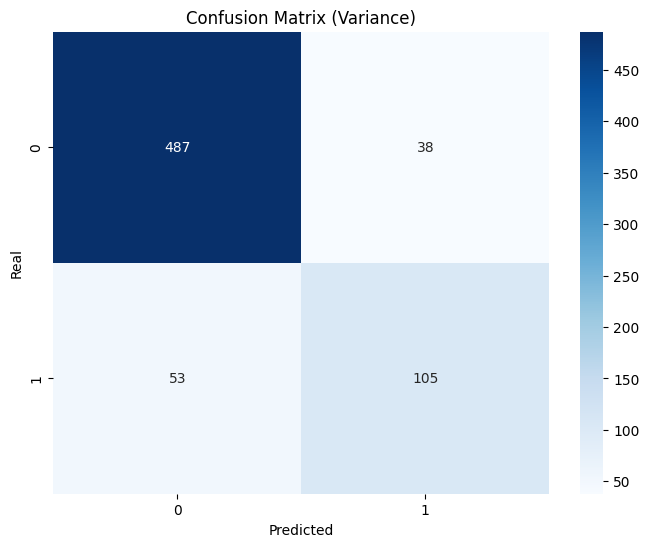


Informe de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       525
           1       0.73      0.66      0.70       158

    accuracy                           0.87       683
   macro avg       0.82      0.80      0.81       683
weighted avg       0.86      0.87      0.86       683



In [18]:

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix (Variance)')


# Guardar la imagen en alta calidad
image_path = "/Users/silvanaruizmedina/Desktop/TFM/Imágenes/confusion_matrix_variance.png"
plt.savefig(image_path, dpi=900, bbox_inches="tight")  # Exportar con DPI alto
plt.show()


# Mostrar el informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))

In [19]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('report_varince.csv')

### SelectfromModel y Randomclassifier

In [20]:

# Entrenar el modelo Random Forest
clf_1 = RandomForestClassifier(n_estimators=200, random_state=42)
X_array= X.to_numpy()
# Etrenamos el modelo
clf_1.fit(X_array, y) 
# Obtener la importancia de características
importances = clf_1.feature_importances_


# Aplicar selección de características
model_1 = SelectFromModel(estimator=clf_1, prefit=True, threshold=None, max_features=70)
X_fs_1 = model_1.transform(X_array)

print("Dimensiones originales de X:", X.shape)
print("Dimensiones después de selección de características:", X_fs_1.shape)

Dimensiones originales de X: (3414, 273)
Dimensiones después de selección de características: (3414, 43)


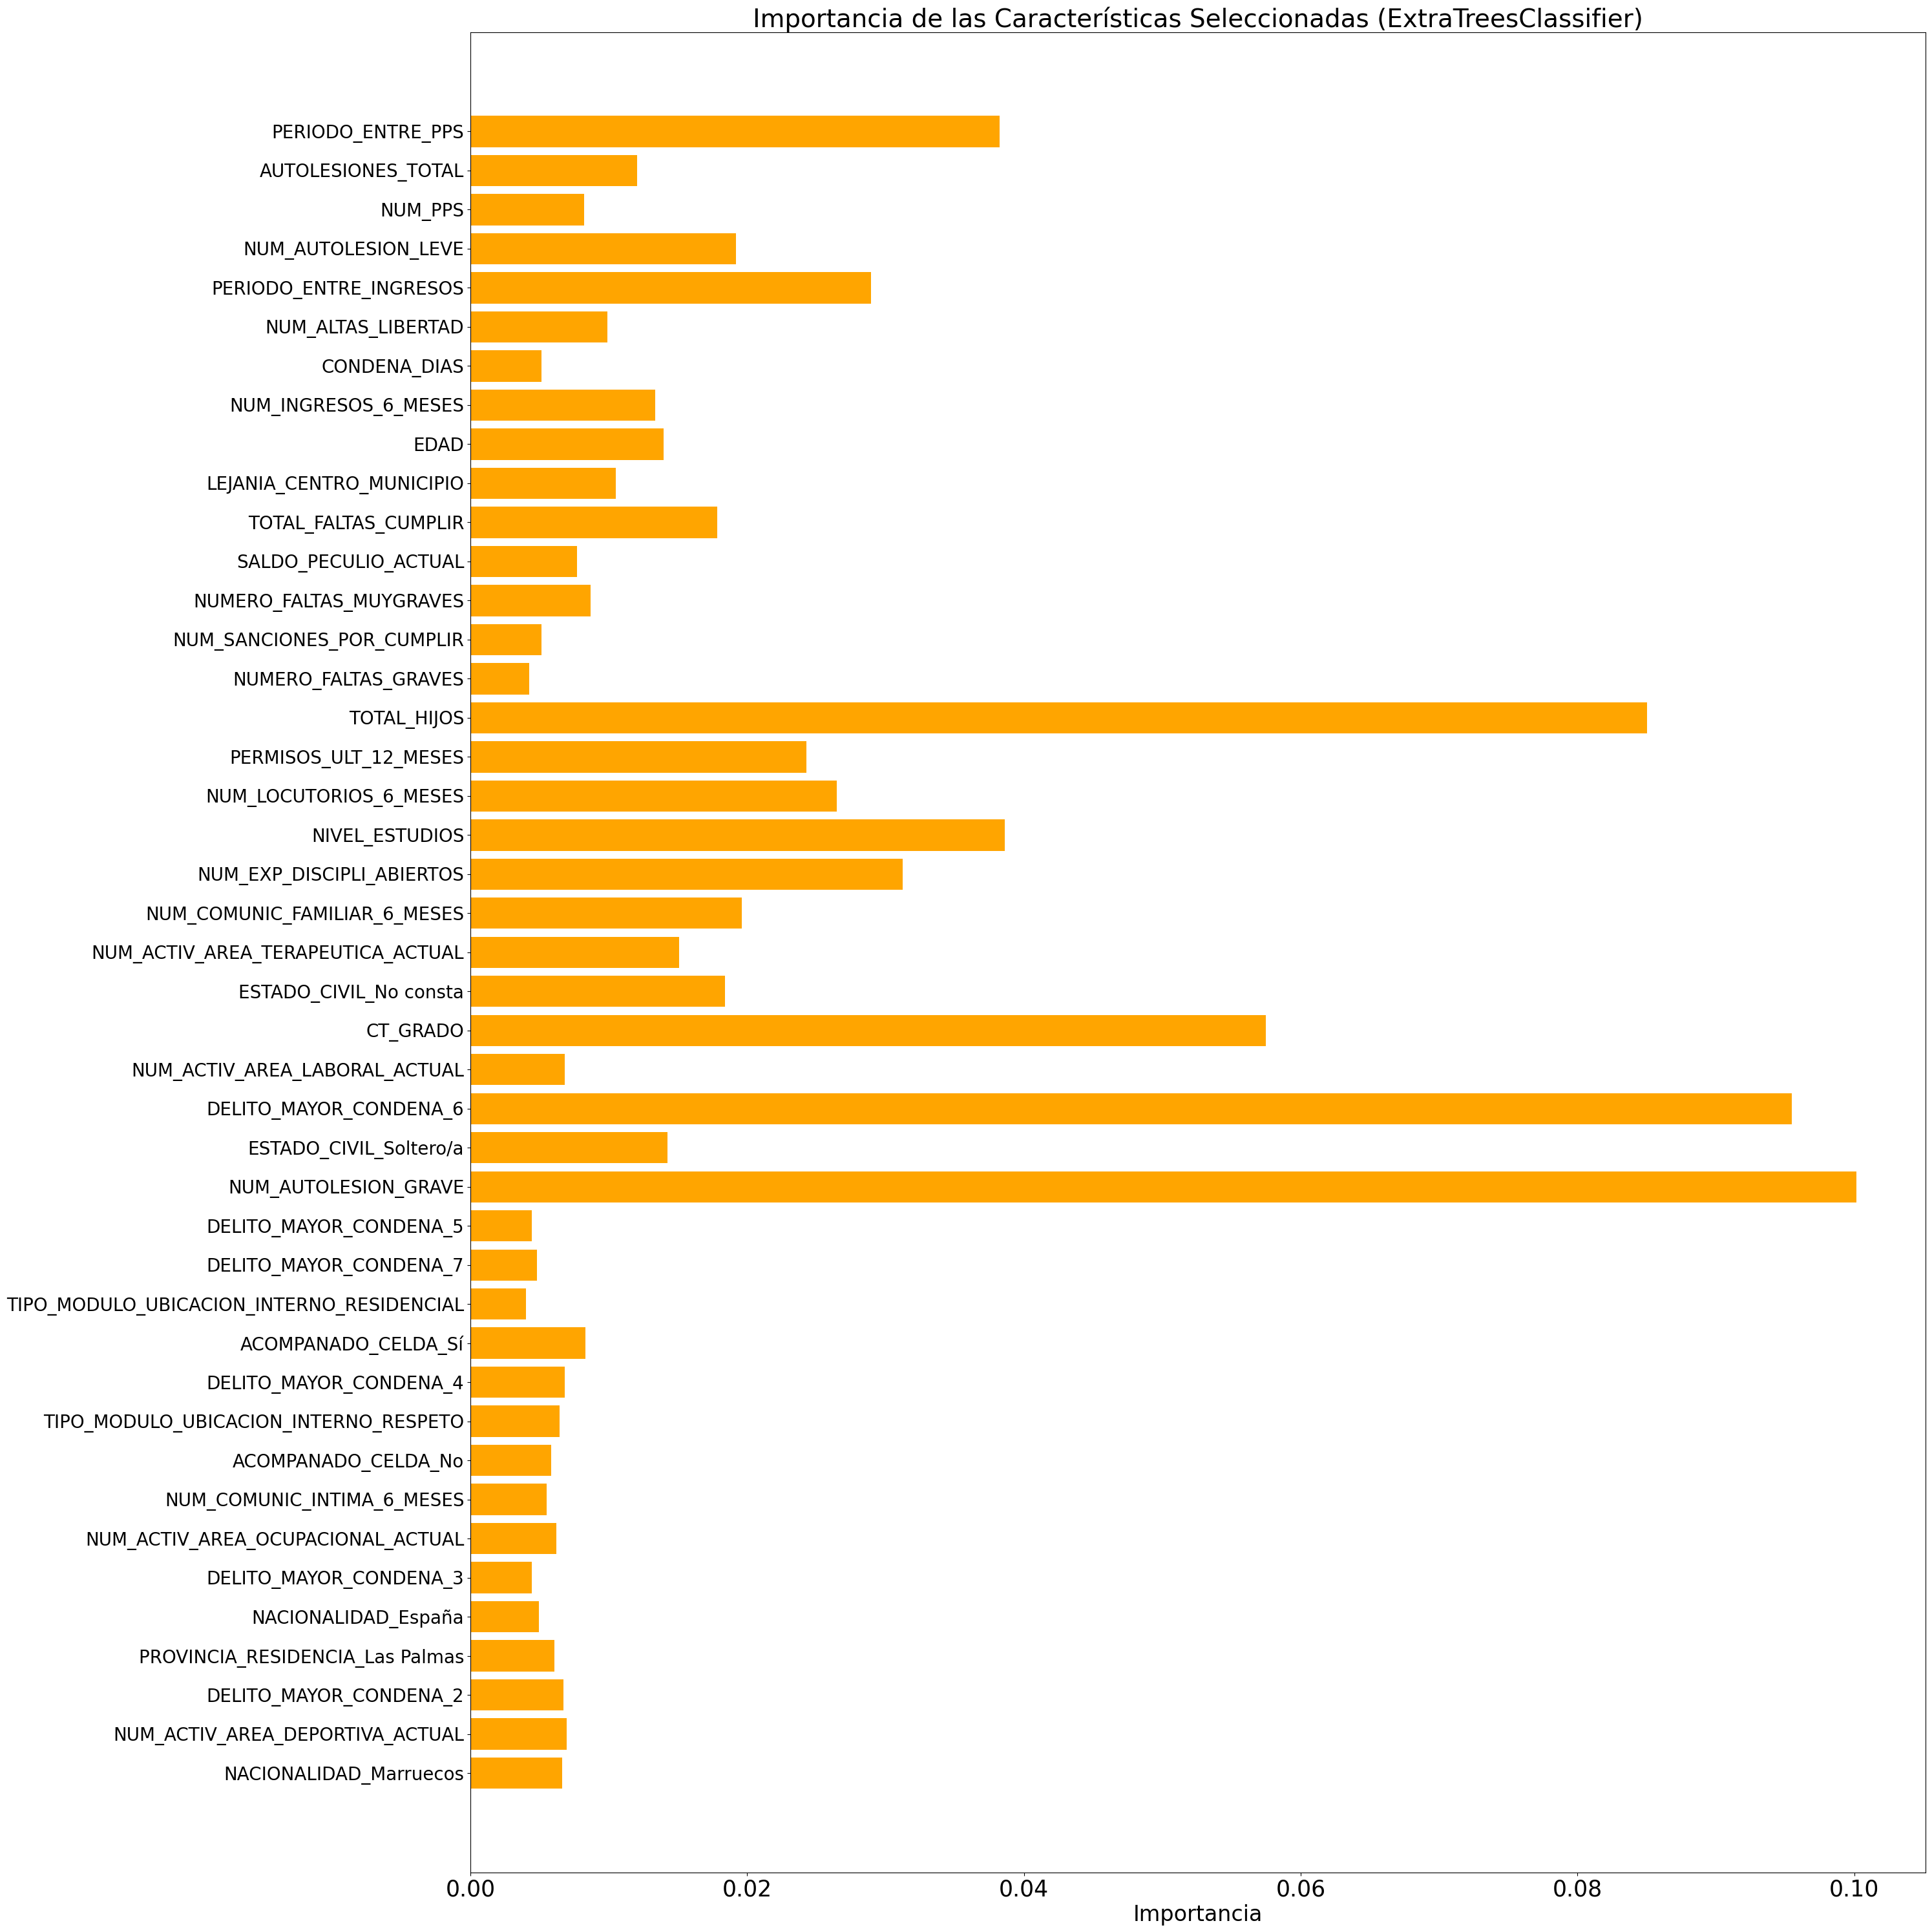

In [21]:
# Obtener los nombres de las características seleccionadas
selected_features_sm = X.columns[model_1.get_support()]
selected_importances_sm = importances[model_1.get_support()]

# Ordenar las características por importancia de mayor a menor
sorted_indices = np.argsort(selected_importances_sm)[::-1]
selected_features_sm = selected_features_sm[sorted_indices]
selected_importances = selected_importances_sm[sorted_indices]

# Create a horizontal bar chart for the selected features
plt.figure(figsize=(30, 30))
plt.barh(selected_features_sm, selected_importances_sm, align='center', color='orange')
plt.xlabel('Importancia', fontsize=24)
plt.title('Importancia de las Características Seleccionadas (ExtraTreesClassifier)', fontsize=28)
plt.gca().invert_yaxis()  # To have the most important features on top
plt.xticks(fontsize=25)
plt.yticks(fontsize=20)
plt.tight_layout()

# Show the plot
plt.show()


In [22]:
X_selected = X[selected_features_sm]
# Evaluar modelos y seleccionar el mejor
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)
mejor_modelo, mejor_score = evaluar_modelos(X_train, X_test, y_train, y_test)
mejor_modelo = grid_search_mejor_modelo(X_train, X_test, y_train, y_test, mejor_modelo, mejor_score)
# Predecir con el mejor modelo
y_pred = mejor_modelo.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)



Resultados de cada modelo:
Decision Tree: 0.8184
Random Forest: 0.8668
Gradient Boosting: 0.8755
Logistic Regression: 0.8433
SVM: 0.8433
XGBoost: 0.8624

El mejor modelo es GradientBoostingClassifier con un score de 0.8755

Aplicando GridSearch para GradientBoostingClassifier...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.8s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.8s
[CV] END .

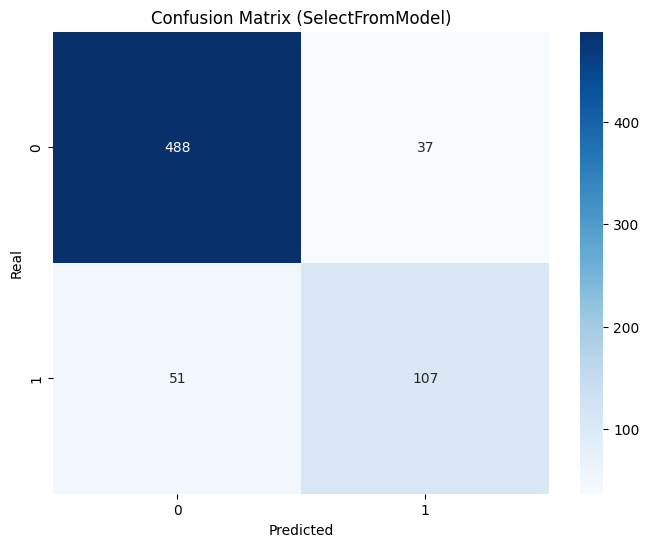

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       525
           1       0.74      0.68      0.71       158

    accuracy                           0.87       683
   macro avg       0.82      0.80      0.81       683
weighted avg       0.87      0.87      0.87       683



In [23]:

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix (SelectFromModel)')
# Guardar la imagen en alta calidad
image_path = "/Users/silvanaruizmedina/Desktop/TFM/Imágenes/confusion_matrix_select.png"
plt.savefig(image_path, dpi=900, bbox_inches="tight")  # Exportar con DPI alto
plt.show()

# Mostrar el informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

In [24]:
report_sm = classification_report(y_test, y_pred, output_dict=True)
df_report_sm = pd.DataFrame(report).transpose()
df_report_sm.to_csv('report_sm.csv')

In [25]:
# Extraer el valor de Accuracy (ya que no forma parte de precision, recall o F1)
accuracy_value = report_sm.pop("accuracy")  # Elimina "accuracy" del diccionario

# Convertir el reporte a DataFrame
df_report_sm = pd.DataFrame(report_sm).transpose()

# Agregar el Accuracy como una fila separada
df_accuracy = pd.DataFrame({"precision": "-", "recall": "-", "f1-score": accuracy_value, "support": sum(report_sm['0']['support'] for label in report_sm if label.isdigit())}, index=["accuracy"])

# Unir los DataFrames
df_report_sm = pd.concat([df_report_sm, df_accuracy])
df_report_sm


,precision,recall,f1-score,support
0,0.90538,0.929524,0.917293,525.0
1,0.743056,0.677215,0.708609,158.0
macro avg,0.824218,0.803369,0.812951,683.0
weighted avg,0.867829,0.871157,0.869018,683.0
accuracy,-,-,0.871157,1050.0


In [26]:
df_report_sm

,precision,recall,f1-score,support
0,0.90538,0.929524,0.917293,525.0
1,0.743056,0.677215,0.708609,158.0
macro avg,0.824218,0.803369,0.812951,683.0
weighted avg,0.867829,0.871157,0.869018,683.0
accuracy,-,-,0.871157,1050.0


In [27]:

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=5, oob_score=True, max_features='sqrt')
trans = BorutaPy(clf, random_state=42, verbose= 2)
sel = trans.fit_transform(X_train.to_numpy(), y_train.to_numpy())
selected_feactures_borupy = trans.support_
selected_feature_name_b = X_train.columns[selected_feactures_borupy]


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	24
Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	24
Iteration: 	10 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	24
Iteration: 	11 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	24
Iteration: 	12 / 100
Confirmed: 	18
Tentative: 	1
Rejected: 	24
Iteration: 	13 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	25


BorutaPy finished running.

Iteration: 	14 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	25


In [28]:

# Filtrar características que existen en X
selected_feature_name_b = [feature for feature in selected_feature_name_b if feature in X.columns]

# Ahora seleccionar las columnas en X
X_selected_b = X[selected_feature_name_b]

# Verificar que X_selected no esté vacío
if X_selected_b.shape[1] == 0:
    raise ValueError("No quedan características seleccionadas en X_selected. Revisa los nombres de las columnas.")

# Asegurar que y es un array
y = np.array(y)

# División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X_selected_b, y, test_size=0.2, random_state=42, stratify=y)

# Evaluar modelos y seleccionar el mejor
mejor_modelo, *_ = evaluar_modelos(X_train, X_test, y_train, y_test)  # Solo tomamos el modelo

# Predecir con el mejor modelo
y_pred = mejor_modelo.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)



Resultados de cada modelo:
Decision Tree: 0.8141
Random Forest: 0.8697
Gradient Boosting: 0.8755
Logistic Regression: 0.8375
SVM: 0.8594
XGBoost: 0.8682

El mejor modelo es GradientBoostingClassifier con un score de 0.8755


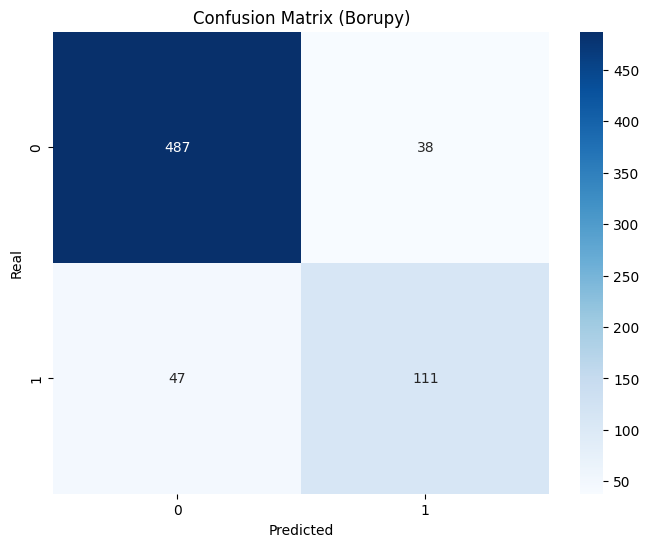

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       525
           1       0.74      0.70      0.72       158

    accuracy                           0.88       683
   macro avg       0.83      0.82      0.82       683
weighted avg       0.87      0.88      0.87       683



In [29]:

# Visualizar la matriz de confusión con correcciones
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix (Borupy)')

# Guardar la imagen en alta calidad
image_path = "/Users/silvanaruizmedina/Desktop/TFM/Imágenes/confusion_matrix_borupy.png"
plt.savefig(image_path, dpi=900, bbox_inches="tight")  # Exportar con DPI alto
plt.show()
# Mostrar el informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

In [30]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('report_boruty.csv')

In [31]:
selected_feature_name_b
selected_features
selected_features_sm

Index(['PERIODO_ENTRE_PPS', 'AUTOLESIONES_TOTAL', 'NUM_PPS',
       'NUM_AUTOLESION_LEVE', 'PERIODO_ENTRE_INGRESOS', 'NUM_ALTAS_LIBERTAD',
       'CONDENA_DIAS', 'NUM_INGRESOS_6_MESES', 'EDAD',
       'LEJANIA_CENTRO_MUNICIPIO', 'TOTAL_FALTAS_CUMPLIR',
       'SALDO_PECULIO_ACTUAL', 'NUMERO_FALTAS_MUYGRAVES',
       'NUM_SANCIONES_POR_CUMPLIR', 'NUMERO_FALTAS_GRAVES', 'TOTAL_HIJOS',
       'PERMISOS_ULT_12_MESES', 'NUM_LOCUTORIOS_6_MESES', 'NIVEL_ESTUDIOS',
       'NUM_EXP_DISCIPLI_ABIERTOS', 'NUM_COMUNIC_FAMILIAR_6_MESES',
       'NUM_ACTIV_AREA_TERAPEUTICA_ACTUAL', 'ESTADO_CIVIL_No consta',
       'CT_GRADO', 'NUM_ACTIV_AREA_LABORAL_ACTUAL', 'DELITO_MAYOR_CONDENA_6',
       'ESTADO_CIVIL_Soltero/a', 'NUM_AUTOLESION_GRAVE',
       'DELITO_MAYOR_CONDENA_5', 'DELITO_MAYOR_CONDENA_7',
       'TIPO_MODULO_UBICACION_INTERNO_RESIDENCIAL', 'ACOMPANADO_CELDA_Sí',
       'DELITO_MAYOR_CONDENA_4', 'TIPO_MODULO_UBICACION_INTERNO_RESPETO',
       'ACOMPANADO_CELDA_No', 'NUM_COMUNIC_INTIMA_6_MESES

In [32]:

selected_feature_name_b = list(selected_feature_name_b)
selected_features = list(selected_features)
selected_features_sm = list(selected_features_sm)
# Guardamos los resultados en un df
max_length = max(len(selected_feature_name_b), len(selected_features), len(selected_features_sm))

# Rellenar listas más cortas con strings vacíos para que todas tengan la misma longitud
selected_feature_name_b += [""] * (max_length - len(selected_feature_name_b))
selected_features += [""] * (max_length - len(selected_features))
selected_features_sm += [""] * (max_length - len(selected_features_sm))
df_features = pd.DataFrame({
    "Selected Feature-Borupy": selected_feature_name_b,
    "Selected Features-Variance": selected_features,
    "Selected Features-SelectFromModel": selected_features_sm
})
df_features.to_csv('feature_tabla.csv')

Lo vamos a hacer con la selección de características de BoruPy que es el que mejor resultados nos da. 

BLENDING

In [52]:
from sklearn.model_selection import learning_curve
def curva_aprendizaje(modelo, X, y,nombre, scaled=True):
    modelo = modelo

    # IMPORTANTE: usa todo X_selected y y para este análisis (no el split train/test)
    X_total = X
    y_total = y

    # Opcional: escalar si lo hacías antes
    if scaled:
        scaler_total = MinMaxScaler()
        X_total_scaled = scaler_total.fit_transform(X_total)

    else:
        X_total_scaled= X_total

    # Curva de aprendizaje
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=modelo,
        X=X_total_scaled,
        y=y_total,
        train_sizes=np.linspace(0.1, 1.0, 8),  # desde 10% hasta 100%
        cv=5,
        scoring='f1',  # Cambia a 'f1', 'roc_auc', etc. si te sirve más
        shuffle=True,
        random_state=42,
        n_jobs=-1
    )

    # Calcular promedios
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    # 📊 Gráfico
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', label='Training')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation')
    plt.xlabel("Quantity of training data")
    plt.ylabel("F1-score")
    plt.title(f"Learning curve - {nombre}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [37]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1️⃣ División del dataset en train (60%), validation (20%), test (20%)
#X_temp, X_test, y_temp, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
X_temp, X_test, y_temp, y_test = train_test_split(X_selected_b, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 de 0.8 = 0.2

# 2️⃣ Definir modelos base con parámetros ajustados
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=20,
    max_features='sqrt',
    bootstrap=True,
    max_samples=0.8,
    oob_score=True,
    random_state=42
)

gb = GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.03,
    max_depth=2,
    min_samples_leaf=40,
    subsample=0.7,
    max_features='sqrt',
    random_state=42
)

hist = HistGradientBoostingClassifier(
    max_depth=3,
    min_samples_leaf=40,
    learning_rate=0.05,
    max_iter=300,
    l2_regularization=1.0,
    early_stopping=True,
    validation_fraction=0.15,
    random_state=42
)

# 3️⃣ Entrenar modelos base con datos de entrenamiento
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
hist.fit(X_train, y_train)

# 4️⃣ Predicciones de modelos base sobre el set de validación (para blending)
pred_rf_val = rf.predict_proba(X_val)[:, 1]
pred_gb_val = gb.predict_proba(X_val)[:, 1]
pred_hist_val = hist.predict_proba(X_val)[:, 1]

# 5️⃣ Crear dataset de entrenamiento para el meta-modelo
X_meta_train = np.column_stack((pred_rf_val, pred_gb_val, pred_hist_val))
y_meta_train = y_val

# Escalar blending inputs
scaler = MinMaxScaler()
X_meta_train_scaled = scaler.fit_transform(X_meta_train)


# 6️⃣ Entrenar meta-modelo
meta_model = LogisticRegression(C=0.5, penalty='elasticnet', solver='saga',l1_ratio=0.3, max_iter=1000, random_state=42)
meta_model.fit(X_meta_train, y_meta_train)

# 7️⃣ Obtener predicciones de los modelos base en el test final
pred_rf_test = rf.predict_proba(X_test)[:, 1]
pred_gb_test = gb.predict_proba(X_test)[:, 1]
pred_hist_test = hist.predict_proba(X_test)[:, 1]

# 8️⃣ Dataset final para evaluación del meta-modelo
X_meta_test = np.column_stack((pred_rf_test, pred_gb_test, pred_hist_test))
X_meta_test_scaled = scaler.transform(X_meta_test)
y_pred = meta_model.predict(X_meta_test)

# 9️⃣ Evaluación del sistema de blending
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("✅ Precisión final del modelo Blending (test):", accuracy)
print("\n🔹 Matriz de Confusión:\n", conf_matrix)
print("\n📊 Classification Report:\n", class_report)

✅ Precisión final del modelo Blending (test): 0.9092240117130308

🔹 Matriz de Confusión:
 [[526  19]
 [ 43  95]]

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94       545
           1       0.83      0.69      0.75       138

    accuracy                           0.91       683
   macro avg       0.88      0.83      0.85       683
weighted avg       0.91      0.91      0.91       683



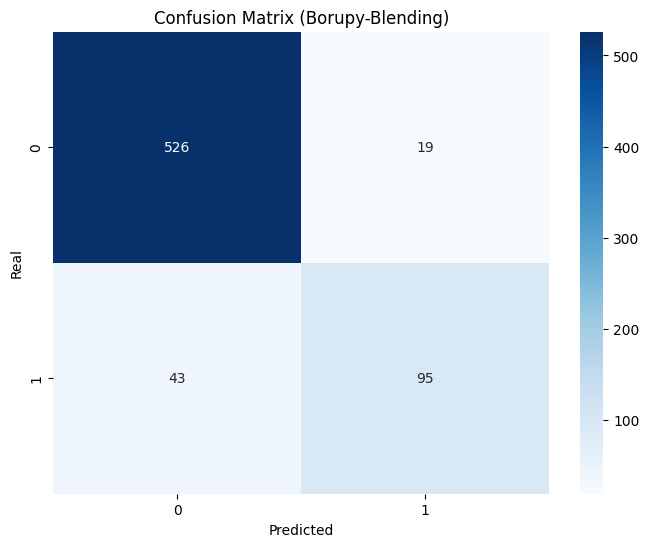

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       545
           1       0.83      0.69      0.75       138

    accuracy                           0.91       683
   macro avg       0.88      0.83      0.85       683
weighted avg       0.91      0.91      0.91       683



In [38]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix (Borupy-Blending)')

# Guardar la imagen en alta calidad
image_path = "/Users/silvanaruizmedina/Desktop/TFM/Imágenes/confusion_matrix_blending.png"
plt.savefig(image_path, dpi=900, bbox_inches="tight")  # Exportar con DPI alto
plt.show()
# Mostrar el informe de clasificación
print("Informe de clasificación:")
print(class_report)

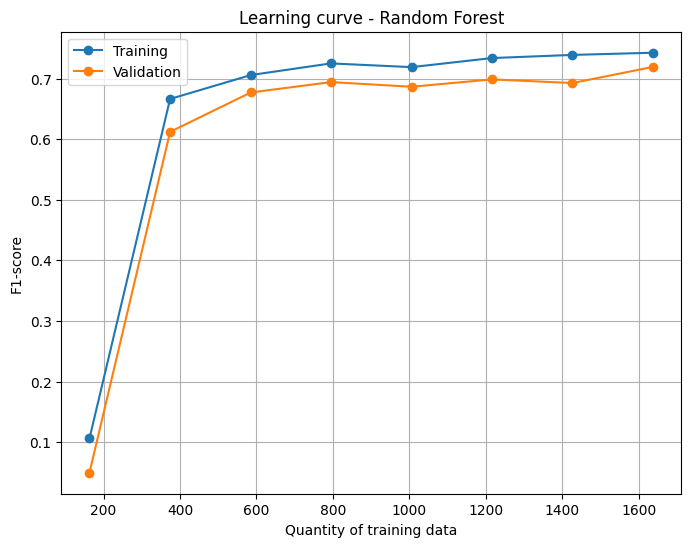

In [53]:
curva_aprendizaje(rf, X_train, y_train, scaled=False, nombre='Random Forest')

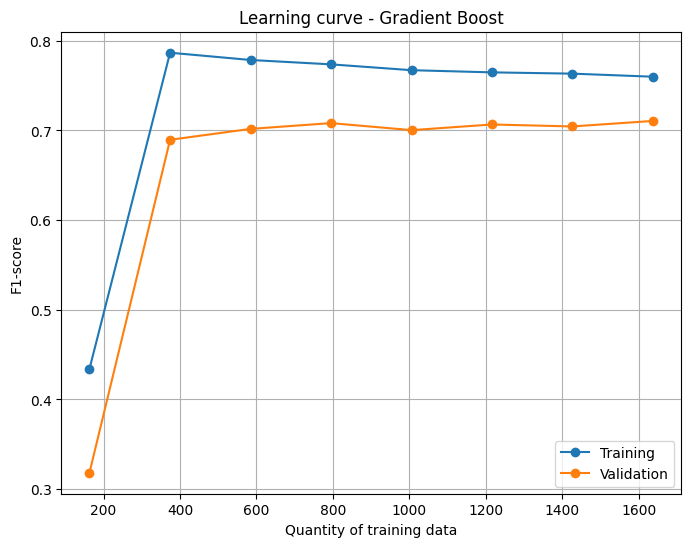

In [54]:
curva_aprendizaje(gb, X_train, y_train, scaled=False, nombre='Gradient Boost')

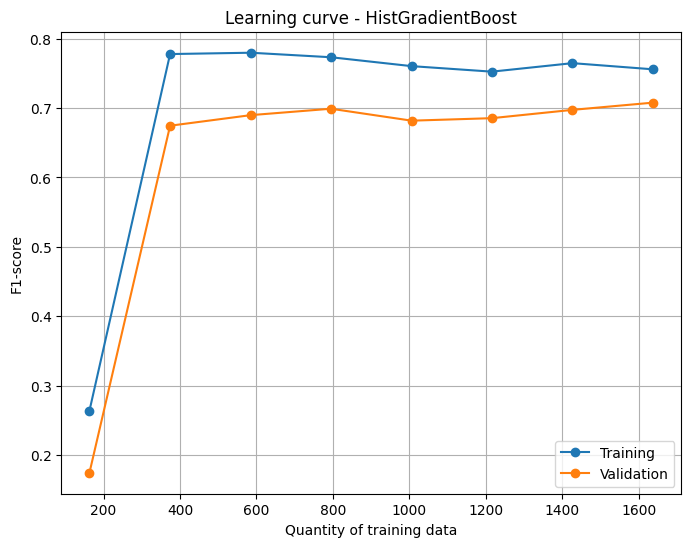

In [55]:
curva_aprendizaje(hist, X_train, y_train, scaled=False, nombre='HistGradientBoost')

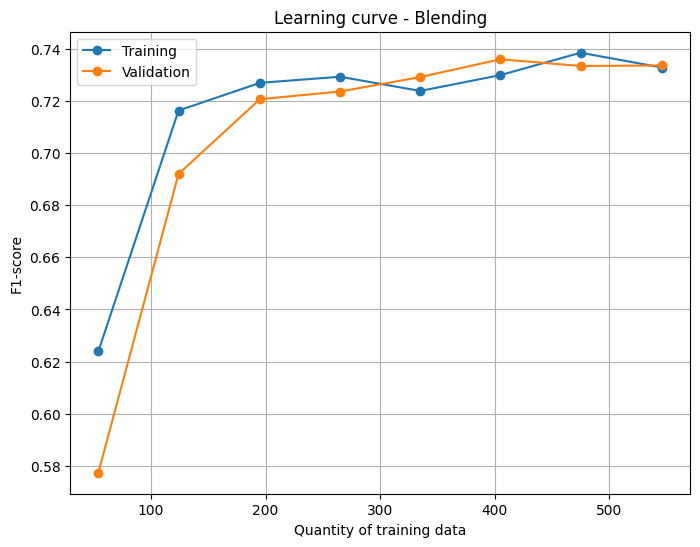

In [58]:
curva_aprendizaje(meta_model, X_meta_train, y_meta_train, scaled=True, nombre='Blending')

In [56]:
nombres_modelos_base = ['Random Forest', 'Gradient Boosting', 'HistGB']
coeficientes = meta_model.coef_[0]
pesos = pd.Series(coeficientes, index=nombres_modelos_base)
pesos = pesos.sort_values(ascending=False)

print("Importancia relativa de cada modelo base:")
print(pesos)  

Importancia relativa de cada modelo base:
Gradient Boosting    2.109307
Random Forest        2.037440
HistGB               1.861532
dtype: float64


<Axes: title={'center': 'Base model weights in the Meta-Learner'}>

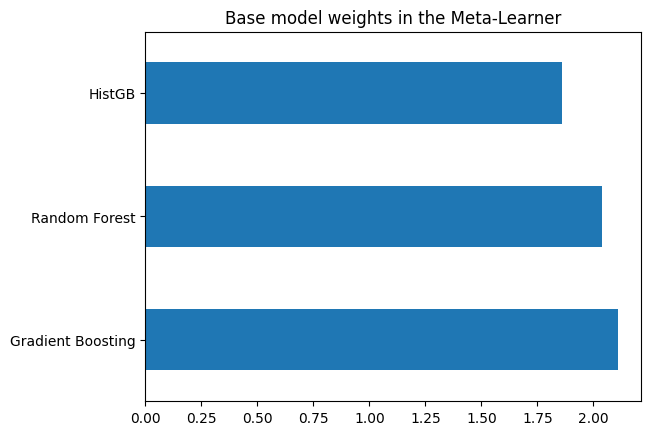

In [57]:
pesos.plot(kind='barh', title='Base model weights in the Meta-Learner')

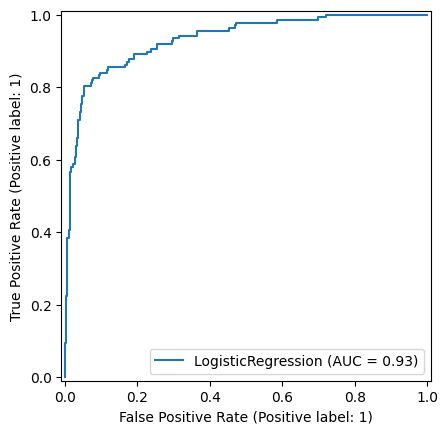

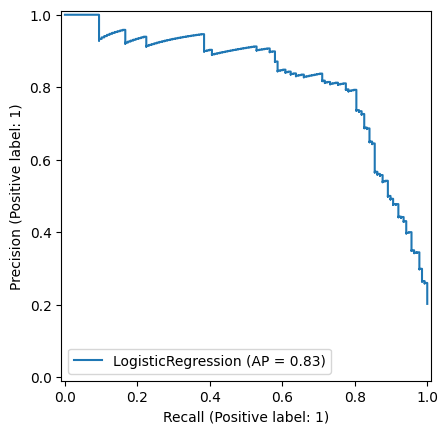

In [45]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
RocCurveDisplay.from_estimator(meta_model, X_meta_test_scaled, y_test)

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(meta_model, X_meta_test_scaled, y_test)

•	Una AUC de 0.93 es excelente. Significa que tu modelo tiene una alta capacidad de discriminación entre clases positivas y negativas.
•	En otras palabras: hay una probabilidad del 93% de que el modelo asigne un score más alto a una clase positiva que a una negativa.
•	La curva está muy cerca de la esquina superior izquierda (ideal), lo que indica que el modelo tiene un bajo falso positivo rate y un alto true positive rate.

•	El área bajo la curva Precision-Recall (Average Precision) mide qué tan preciso es el modelo a medida que aumenta el recall.
•	Un AP : de 0.82 indica que el modelo mantiene un buen equilibrio entre precisión y sensibilidad.
ConclusionEl modelo recupera bien las clases positivas sin sacrificar demasiada precisión (Buen equilibrio)


In [46]:
from sklearn.inspection import permutation_importance
def plot_permutation_importance(model, model_name, X, y, feature_names, top_n=18, scoring='f1'):
    
    result = permutation_importance(
        model, X, y,
        n_repeats=30,
        random_state=42,
        n_jobs=-1,
        scoring=scoring
    )

    importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)

    # Gráfico
    plt.figure(figsize=(8, 5))
    importances[:top_n].plot(kind='barh')
    plt.title(f'Importancia de features - {model_name} (por permutación)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

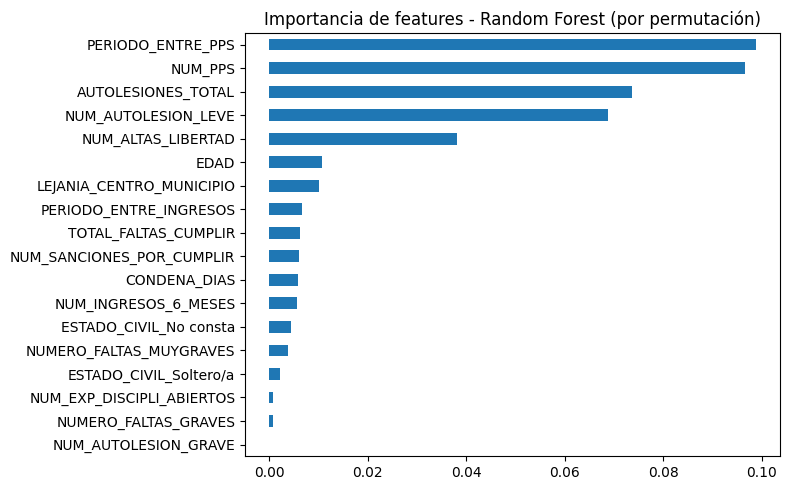

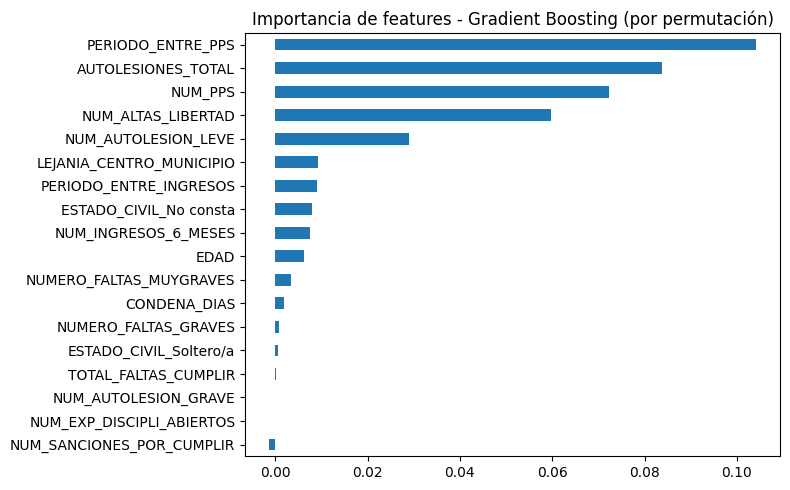

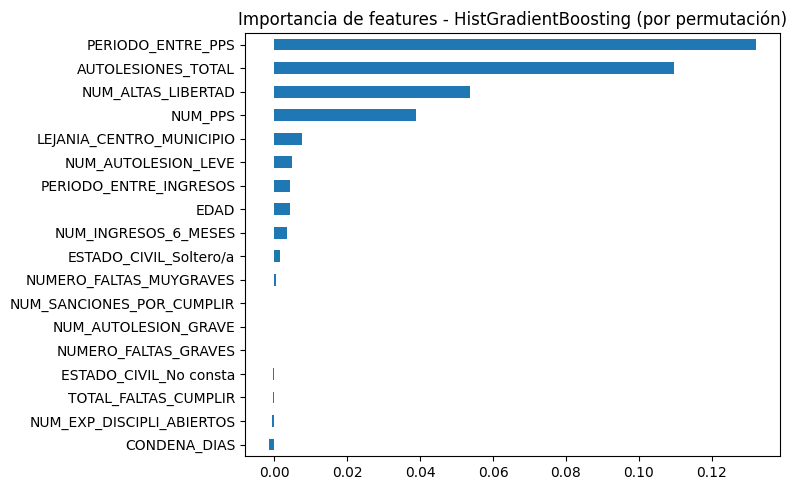

In [47]:
# Nombres de variables
feature_names = X_train.columns

# Llamadas
plot_permutation_importance(rf, "Random Forest", X_train, y_train, feature_names)
plot_permutation_importance(gb, "Gradient Boosting", X_train, y_train, feature_names)
plot_permutation_importance(hist, "HistGradientBoosting", X_train, y_train, feature_names)

In [48]:
import pickle as pl
with open('modelo_carceles.pkl', 'wb') as f:
    pl.dump({
    'modelo': meta_model,
    'scaler': scaler,
    'features': list(X_selected_b.columns),
    'rf': rf,
    'gb': gb,
    'hist': hist
}, open('modelo_carceles.pkl', 'wb'))